In [2]:
import joblib, pandas as pd, json
from pathlib import Path

pipe = joblib.load("modelo_obj3/extratrees_obj3_pipeline.joblib")
meta = json.load(open("modelo_obj3/metadata.json", "r", encoding="utf-8"))
features = meta["feature_names"]; classes = meta["class_names"]

df = pd.read_csv("dataset_hoteles_tunja_numerico_con_target.csv", encoding="utf-8-sig")
X_sample = df[features].head(5)
pred_codes = pipe.predict(X_sample)
pred_labels = [classes[i] for i in pred_codes]
list(zip(pred_codes, pred_labels))


[(2, 'premium'),
 (1, 'precio-calidad'),
 (2, 'premium'),
 (0, 'económico'),
 (1, 'precio-calidad')]

✔ Guardado: figuras_obj3\pca_segmento.png
Varianza explicada PCA: PC1=0.297, PC2=0.163, Total=0.460


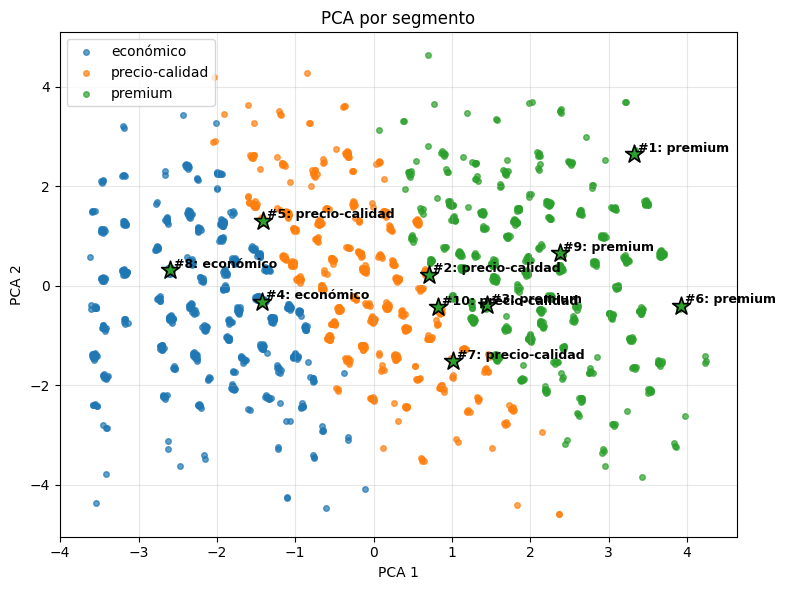

In [1]:
# =========================================
# Visualizaciones del modelo — SOLO PCA (limpio) + overlay opcional de N predicciones
# =========================================
import json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit
import joblib

# ------------------ Config ------------------
MODEL_DIR = Path("modelo_obj3")
META_JSON = MODEL_DIR / "metadata.json"
TOP_CSV   = MODEL_DIR / "top25_importancias.csv"
PIPE_PATH = MODEL_DIR / "extratrees_obj3_pipeline.joblib"

FIG_DIR   = Path("figuras_obj3"); FIG_DIR.mkdir(exist_ok=True)

RAW_PATH  = Path(r"C:\Users\FABIO\Downloads\dataset_hoteles_tunja_50000_segmentado.csv")   # CSV original
NUM_PATH  = Path("dataset_hoteles_tunja_numerico_con_target.csv")                           # CSV numérico

SUBSAMPLE_N   = 2000   
TOPK_FALLBACK = 50     
OVERLAY_N     = 10   

# ------------------ Metadatos ------------------
meta = json.load(open(META_JSON, "r", encoding="utf-8"))
class_names = meta["class_names"]
target_name = meta.get("target", "segmento")
feature_names_model = meta["feature_names"]

# ------------------ Auxiliares ------------------
def scatter_by_class(Z, y_codes, title, out_png, stars=None):
    plt.figure(figsize=(8,6))
    for i, cname in enumerate(class_names):
        m = (y_codes == i)
        plt.scatter(Z[m,0], Z[m,1], s=16, alpha=0.70, label=cname)
    if stars:
        for s in stars:
            x, y = s["xy"]
            plt.scatter(x, y, s=180, c=s.get("color","tab:gray"),
                        marker="*", edgecolor="k", linewidths=1.2, zorder=3)
            if "label" in s:
                plt.text(x+0.05, y+0.05, s["label"], fontsize=9, weight="bold")
    plt.title(title)
    plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
    plt.grid(True, alpha=0.3); plt.legend(loc="best")
    plt.tight_layout(); plt.savefig(out_png, dpi=180)
    # plt.show()
    print("✔ Guardado:", out_png)

def raw_to_matrix(df_raw):
    # ignorar textos muy largos
    ignore = []
    for c in df_raw.columns:
        if df_raw[c].dtype == "object" and c != target_name:
            if df_raw[c].astype(str).str.len().fillna(0).mean() > 40:
                ignore.append(c)
    y_codes = pd.Categorical(df_raw[target_name], categories=class_names).codes
    X_num = df_raw.drop(columns=[target_name] + ignore)

    X = pd.get_dummies(X_num, drop_first=True)              # dummies sin primera categoría
    X = X.select_dtypes(include="number").fillna(0.0)       # solo numéricas
    cont_cols = [c for c in X.columns if X[c].nunique() > 20]
    if len(cont_cols) >= 5:                                 # prioriza continuas si hay suficientes
        X = X[cont_cols]
    return X, y_codes, ignore

def numeric_topK_matrix(df_num, K):
    y_codes = pd.Categorical(df_num[target_name], categories=class_names).codes
    top = pd.read_csv(TOP_CSV); top_cols = top["feature"].tolist()
    top_cols_used = top_cols[:min(K, len(top_cols))]
    X = df_num[top_cols_used].copy()
    X = SimpleImputer(strategy="median").fit_transform(X)
    return X, y_codes, top_cols_used

# ------------------ Construcción de X,y para PCA ------------------
used_source = None
top_cols_used = None
ignore_cols_for_raw = None

if RAW_PATH.exists():
    df_raw = pd.read_csv(RAW_PATH, encoding="utf-8-sig")
    if target_name not in df_raw.columns:
        raise ValueError(f"No está la etiqueta '{target_name}' en el RAW.")
    X, y_codes, ignore_cols_for_raw = raw_to_matrix(df_raw)
    used_source = "RAW"
else:
    print("⚠ No se encontró el RAW. Usaré el dataset numérico con Top-K features.")
    if not NUM_PATH.exists():
        raise FileNotFoundError("Tampoco existe dataset_hoteles_tunja_numerico_con_target.csv.")
    df_num = pd.read_csv(NUM_PATH, encoding="utf-8-sig")
    if target_name not in df_num.columns:
        raise ValueError(f"No está la etiqueta '{target_name}' en el dataset numérico.")
    X, y_codes, top_cols_used = numeric_topK_matrix(df_num, TOPK_FALLBACK)
    used_source = "NUM"

# Submuestreo para el fondo (sin depender del overlay)
if SUBSAMPLE_N and SUBSAMPLE_N < len(y_codes):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=SUBSAMPLE_N, random_state=42)
    _, idx = next(sss.split(np.zeros_like(y_codes), y_codes))
    X = X[idx] if isinstance(X, np.ndarray) else X.iloc[idx].reset_index(drop=True)
    y_codes = y_codes[idx]

# ------------------ PCA limpio (imputación + escalado + PCA) ------------------
imputer = SimpleImputer(strategy="median").fit(X if isinstance(X, np.ndarray) else X.values)
sc      = StandardScaler()
pca     = PCA(n_components=2, random_state=42)

X_mat = X if isinstance(X, np.ndarray) else X.values
X_std = sc.fit_transform(imputer.transform(X_mat))
Z_pca = pca.fit_transform(X_std)

# ------------------ Overlay de N predicciones (robusto al submuestreo) ------------------
stars_pca = None
if OVERLAY_N and PIPE_PATH.exists():
    try:
        pipe = joblib.load(PIPE_PATH)
        df_num_full = pd.read_csv(NUM_PATH, encoding="utf-8-sig")  # el pipeline usa el numérico
        classes = meta["class_names"]

        # Predicciones del pipeline sobre las N primeras del numérico
        XN_pipe = df_num_full[feature_names_model].head(OVERLAY_N)
        pred_codes_N = pipe.predict(XN_pipe)
        realN        = pd.Categorical(df_num_full[target_name].head(OVERLAY_N), categories=classes).codes
        cols         = ["tab:green" if p==t else "tab:red" for p,t in zip(pred_codes_N, realN)]

        # Reconstruir esas N con el MISMO preprocesamiento del PCA para proyectarlas
        if used_source == "RAW":
            firstN_raw = df_raw.iloc[:OVERLAY_N].drop(columns=[target_name] + (ignore_cols_for_raw or []))
            XN_raw = pd.get_dummies(firstN_raw, drop_first=True)
            # Alinear columnas con las del PCA si X es DataFrame
            if not isinstance(X, np.ndarray):
                XN_raw  = XN_raw.reindex(columns=X.columns, fill_value=0)
                XN_vals = XN_raw.select_dtypes(include="number").fillna(0.0).values
            else:
                XN_vals = XN_raw.select_dtypes(include="number").fillna(0.0).values
        else:
            if top_cols_used is None:
                raise RuntimeError("No se han definido top_cols_used en ruta NUM.")
            XN_vals = df_num_full[top_cols_used].head(OVERLAY_N).to_numpy()

        ZN = pca.transform(sc.transform(imputer.transform(XN_vals)))

        stars_pca = [{"xy": (ZN[i,0], ZN[i,1]),
                      "label": f"#{i+1}: {classes[pred_codes_N[i]]}",
                      "color": cols[i]} for i in range(len(ZN))]
    except Exception as e:
        print("Overlay de N predicciones no generado:", e)

# ------------------ Plot final ------------------
scatter_by_class(Z_pca, y_codes, "PCA por segmento", FIG_DIR / "pca_segmento.png", stars=stars_pca)
print(f"Varianza explicada PCA: PC1={pca.explained_variance_ratio_[0]:.3f}, "
      f"PC2={pca.explained_variance_ratio_[1]:.3f}, Total={pca.explained_variance_ratio_[:2].sum():.3f}")
